In [0]:
!pip install -U -q PyDrive
!pip install transformers fairseq sentencepiece fastBPE regex requests sacremoses subword_nmt

!git clone https://github.com/shshnk94/xencoder.git

#Vanilla Transformer as in Vaswani et. al
!git clone https://github.com/moses-smt/mosesdecoder.git
!git clone https://github.com/rsennrich/subword-nmt.git
!wget https://dl.fbaipublicfiles.com/fairseq/models/wmt14.en-fr.joined-dict.transformer.tar.bz2
!tar -xvf wmt14.en-fr.joined-dict.transformer.tar.bz2

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.discovery import build

import h5py
import os, re
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from fairseq.models.transformer import TransformerModel
from transformers import XLMRobertaModel
from xencoder.xencoder.data.dataloader import ParallelDataset, PadSequence

In [0]:
# Read dataset - sampled data from original dataset comprising of 12,000 sentences for the purpose of training PAN
def load_data(file_id, file_name):
  
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  if not os.path.exists("./data"):
    os.mkdir("data")

  handle = drive.CreateFile({'id': file_id})
  handle.GetContentFile('data/' + file_name)

load_data('1CZKEkagdx0-lID9MazgHpoK-0A09tDm7', 'sampled.hi.h5')
load_data('151lHgBxpGjD_iuIVnypJN6a_V1PPg7kU', 'sampled.en.h5')

In [0]:
# Read sampled dataset and split into training and validation sets
src = h5py.File('data/sampled.hi.h5', 'r').get('dataset')
tgt = h5py.File('data/sampled.en.h5', 'r').get('dataset')

print(src.shape)
print(tgt.shape)

msk = np.random.rand(src.shape[0]) < 0.9
src_train, tgt_train = src[msk], tgt[msk]
src_test, tgt_test = src[~msk], tgt[~msk]

# #Sampling
# src_train, tgt_train = src_train[:10000], tgt_train[:10000]
# src_test, tgt_test = src_test[10000:], tgt_test[10000:]

h5py.File('data/src_train.h5', 'w').create_dataset('dataset', (src_train.shape[0],), data=src_train)
h5py.File('data/tgt_train.h5', 'w').create_dataset('dataset', (tgt_train.shape[0],), data=tgt_train)
h5py.File('data/src_test.h5', 'w').create_dataset('dataset', (src_test.shape[0],), data=src_test)
h5py.File('data/tgt_test.h5', 'w').create_dataset('dataset', (tgt_test.shape[0],), data=tgt_test)

print(h5py.File('data/src_train.h5', 'r').get('dataset').shape)
print(h5py.File('data/tgt_train.h5', 'r').get('dataset').shape)
print(h5py.File('data/src_test.h5', 'r').get('dataset').shape)
print(h5py.File('data/tgt_test.h5', 'r').get('dataset').shape)

In [0]:
# Load data using dataloader - batch size set to 128
pad_sequence = PadSequence(1)
train_loader = DataLoader(ParallelDataset('data/src_train.h5', 'data/tgt_train.h5'),
                          shuffle=True,
                          batch_size=128,
                          collate_fn=pad_sequence)

val_loader = DataLoader(ParallelDataset('data/src_test.h5', 'data/tgt_test.h5'),
                        shuffle=True,
                        batch_size=128,
                        collate_fn=pad_sequence)

In [0]:
# Pivot Adapter Network Model 
# XLMR encoder is used for source
# Pivot encoder is that of fairseq
# We introduce non-linearity by making using of a neural network with one hidden layer. ReLU activation is used in the network.
# The weights for the 2 linear layers are initialized using the xavier normal initialization.
import torch.nn as nn

class PivotAdapterNetwork(nn.Module):

    def __init__(self, src_encoder, tgt_encoder, pad_token_id):

        super(PivotAdapterNetwork, self).__init__()

        self.src_encoder = src_encoder
        self.tgt_encoder = tgt_encoder
        self.pad_token_id = pad_token_id

        self.pan = nn.Sequential(nn.Linear(1024, 768), 
                                 nn.ReLU(), 
                                 nn.Linear(768, 1024)
                                 )
        self.pan.apply(self._init_weights)

    def _init_weights(self, m):
      if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

    def forward(self, source, target):

        source = self.src_encoder(source)[0].mean(axis=1)
        source = self.pan(source)

        lengths = (target != self.pad_token_id).sum(axis=1)
        target = self.tgt_encoder(target, lengths)[0].transpose(0,1).mean(axis=1)

        return source, target

In [0]:
# Instantiate model by passing required encoders.
def build_model():

  src_encoder = XLMRobertaModel.from_pretrained('xlm-roberta-large')

  en2fr = TransformerModel.from_pretrained('wmt14.en-fr.joined-dict.transformer/',
                                           checkpoint_file='model.pt',
                                           bpe='subword_nmt',
                                           bpe_codes='wmt14.en-fr.joined-dict.transformer/bpecodes')
  tgt_encoder = [model for name, model in en2fr.named_modules() if name == 'models.0.encoder'][0]

  model = PivotAdapterNetwork(src_encoder, tgt_encoder, 1)

  return model

In [0]:
# This is for the purpose of plotting the training and validation loss.
!pip install tensorboard
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
# !ls '/content/gdrive/My Drive'

In [0]:
# To store model checkpoint
model_name = 'model.ckpt'
model_path = F"/content/gdrive/My Drive/NLP Project/{model_name}" 
path = "/content/gdrive/My Drive/NLP Project/"
# model_rpath = F"/content/gdrive/My Drive/NLP Project/model_1e5.ckpt"

In [0]:
# Call the build model functionality
from time import time
import pickle as pkl

seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

writer = SummaryWriter('logs/')
best_valid_loss = float('inf')
training_loss_values = []
validation_loss_values = []

model = build_model()

# model = torch.load(model_rpath)
model.src_encoder.eval()
model.tgt_encoder.eval()

for name, param in model.named_parameters():
    param.requires_grad = False if 'encoder' in name else True

In [0]:
# Start of training loop. We are using Mean Square Error as loss function. Learning rate is 1e^-6. Adam optimizer is used.
# 90 percent of training data is used in the training and remaining 10 percent used in Validation
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

for epoch in range(100):

    model.train()
    print('======== Epoch ========', epoch)
    start_time = time()
    total_loss = 0
		  
    for source, target in train_loader:

        model.zero_grad()        
        source, target = model(source, target)
        # print(model)
        #l1_weight = model.pan[0].weight
        #l2_weight = model.pan[2].weight
        # fin_weight = torch.mm(linear1_weight, linear2_weight)
        
        loss = criterion(source, target)
  
        # l1_reg = torch.norm(((torch.mm(torch.transpose(fin_weight, 0, 1), fin_weight) - identity)), 1)
        # loss += l1_reg

        total_loss += loss.item()

        loss.backward()

        optimizer.step()
		  
    avg_train_loss = total_loss / len(train_loader)
    training_loss_values.append(avg_train_loss)

    writer.add_scalar('Train/Loss', avg_train_loss, epoch)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Running Validation...")

    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0

    for source, target in val_loader:
			
      source, target = model(source, target)
      with torch.no_grad():        
        loss = criterion(source, target)
        eval_loss += loss
        nb_eval_steps += 1
    
    avg_valid_loss = eval_loss/nb_eval_steps
    validation_loss_values.append(avg_valid_loss)

    # if avg_valid_loss < best_valid_loss:
    #   best_valid_loss = avg_valid_loss
      # l1_weight = model.pan[0].weight
      # l2_weight = model.pan[2].weight
      
      # with open(path + 'l1_weight.pkl', 'wb') as handle1:
      #   pkl.dump(l1_weight, handle1)
      # with open(path + 'l2_weight.pkl', 'wb') as handle2:
      #   pkl.dump(l2_weight, handle2)
      # handle1.close()
      # handle2.close()
      # torch.save(model, 'model.ckpt')
    #   torch.save(model, model_path)

    writer.add_scalar('Valid/Loss', avg_valid_loss, epoch)
    writer.flush()

    print("Average validation loss: {0:.2f}".format(avg_valid_loss))
    print("Time taken by epoch: {0:.2f}".format(time() - start_time))

writer.close()

In [0]:
# Plot training and validation loss using tensorboard
%tensorboard --logdir=logs/

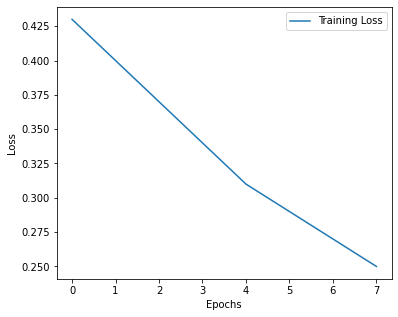

In [2]:
# Plot training and validation loss using matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 5)
plt.plot([0.43, 0.4, 0.37, 0.34, 0.31, 0.29, 0.27, 0.25], label='Training Loss')
#plt.plot(validation_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()